<div style='padding:5px'><font style='font-weight:bold;font-size:32px;color:#2c3393;'>Here Comes The Sun: Clark Solar Power Plant</font></div>
<div style='padding:5px'><font style='font-weight:bold;font-size:24px;color:#2c3393;'>LT16 - Sandro Silva and Jac Lin Yu</font></div>
<div style='padding:5px'><font style='font-weight:bold;font-size:15px;color:#2c3393;'>Individual Project of Jac Lin Yu</font><div>

------------

<font style='font-weight:bold;font-size:32px;color:#2c3393;'>Table of Contents</font>


<font style='font-size:16px'>
    
**[1. Problem Statement](#problem-statement)**

**[2. Methodology](#methodology)**

  * [2.1. Loading Prerequisites](#preq)
  * [2.2. Dataset and Preprocessing](#data)
  * [2.3. Train, Validation, Test Split and Batch Generation](#train)
  * [2.4. Determining the Benchmark](#benchmark)
  * [2.5. Model Training and Selection](#model)
      * [2.5.1 LSTM with 64 nodes](#lstm1)
      * [2.5.2 LSTM with 32 nodes](#lstm2)
      * [2.5.3 Stacked LSTM with 64 and 32 nodes](#lstm3)
      * [2.5.4 Stacked LSTM with 32 and 64 nodes](#lstm4)   

**[3. Results and Discussions](#results)**
  * [3.1. Results](#res)
  * [3.2. Discussions and Recommendations](#discussions)
    
**[4. Summary and Main Learning Points](#summary)**
  * [4.1. Summary](#summary)
  * [4.1. Main Learning Points](#main)
</font>

<div id="problem-statement"/>
<div style='padding:3px;'> <font style='font-weight:bold;font-size:20px;color:#2c3393;'>1. Problem Statement</font></div>

<div style='padding-left: 20px; text-align: justify; font-size:16px; line-height:1.6'>
With the threat of climate change, governments and industries needed to make adjustments as a response to the changes in the priorities of the people. Being one of the biggest contributors to greenhouse gases, the energy industry has shifted its focus away from traditional fuel sources, such as oil and coal, to more alternative and sustainable solutions, such as hydroelectric, solar, and wind. This movement, however, poses new threats and challenges to existing power grids across the world due to the inherent variability and intermittency of renewable fuel source. The disruptions in the power grids and the possibility of an imbalanced load threaten to overwhelm the grid operators.
<br><br> 
Renewable energy forecasting, in particular for solar generation supply as this is the most volatile renewable power source, may provide grid operators the ability to predict and balance energy generation and consumption. In addition, power grid operators will be able to balance and schedule the distribution of generated power for not only renewable power plants but also conventional (and rigid) power plants, such as coal and natural gas. This is currently important to the Philippines, as the Department of Energy has given priority to solar power plants. The government has promised to buy all power these plants produce at a fixed rate. This encourages production which increases supply, but demand remains constant. Therefore, conventional plants need to adjust their production or incur loses and cause instability to the grid.  
</div>

<div id="methodology"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:20px;color:#2c3393;'>2. Methodology</font></div>

<div id="preq"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.1 Loading Prerequisites</font></div>

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

<div id="data"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.2 Dataset and Preprocessing</font></div>

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
Here, we will load the already cleaned preprocessed dataset of solar generation per plant per hour.
The cleaning was processed outside of this notebook, and followed a framework which follows the industry standard of imputing missing values.
  
    
<b>To list a few processes:</b>
    - using the average between the before(t-1) and after hour(t+1)
    - using a 1-week average of all similar intervals 
    (ex, if empty during hour 6 of dec 20, take the moving average of all hour 6 from dec 13-dec19)
    - using a 4-week moving average of that specific hour and day of the week 
    (ex, if empty during hour 6 of dec 20, we take average of hour 6(dec 13, 6, 29, 22)
</font></div>

In [3]:
df = pd.read_excel('solar_dataset.xlsx', 
                   sheet_name='subic', 
                   parse_dates=['DATETIME'])

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
Listed below are the columns and the corresponding datatype.
    </font></div>

In [4]:
df.dtypes

DATETIME         datetime64[ns]
YEAR                      int64
MONTH                     int64
DAY                       int64
HOUR                      int64
RESOURCE_ID              object
MW                      float64
Location                 object
Temperature             float64
Dew Point               float64
Humidity                float64
Wind Speed                int64
Wind Gust                 int64
Pressure                float64
Condition                object
Location_Name            object
dtype: object

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Drop some columns such as location, resource ID, and year. The information regarding the specific plant is unimportant since the scope has already been specified, therefore, there is only one value for each of the specified column. The year is not important since weather has no seasonality in terms of year.
</font></div>

In [7]:
df.drop(['Location_Name', 'Location', 'YEAR', 'RESOURCE_ID'],axis=1,inplace=True)

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    It is customary in traditional time-series regression to convert the <code>month</code>, <code>day</code>, 
    <code>hour</code> into categorical data, which will be later used in one-hot encoding. In addition, this is the usual preprocessing used in the energy industry here in the Philippines.
</font></div>

In [6]:
df.MONTH = df.MONTH.astype('str')
df.DAY = df.DAY.astype('str')
df.HOUR = df.HOUR.astype('str')

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Let us append the main <code>df</code> with the one-hot encoded dataframe. These columns need to be further processed because keeping them as they are will give the model the wrong idea that months, day, hour, and conditions that have higher values are more significant. 
</font></div>

In [8]:
df0 = df.join(pd.get_dummies(df[['MONTH','DAY','HOUR','Condition']]))

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Further dropping of columns as well as reordering of columns
</font></div>

In [12]:
df0 = df0.drop(['DATETIME','MONTH','DAY','HOUR','Condition'],
               axis=1)

In [13]:
df0 = df0[['Temperature','MW'] + df0.columns[2:].tolist()].copy()

In [14]:
df0 = df0.astype('float')

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Final <code>DataFrame</code> to be used
</font></div>

In [15]:
df0.head()

,Temperature,MW,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,MONTH_1,MONTH_10,MONTH_11,...,Condition_Partly Cloudy,Condition_Partly Cloudy / Windy,Condition_Rain,Condition_Rain / Windy,Condition_Rain Shower,Condition_Showers in the Vicinity,Condition_T-Storm,Condition_T-Storm / Windy,Condition_Thunder,Condition_Thunder in the Vicinity
0,72.0,0.0,68.0,88.0,8.0,0.0,29.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,73.0,0.0,68.0,83.0,10.0,0.0,29.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,75.0,0.0,70.0,83.0,9.0,0.0,29.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,75.0,0.0,70.0,83.0,0.0,0.0,29.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73.0,0.0,70.0,88.0,12.0,0.0,29.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df0.shape

(24018, 103)

In [17]:
plant_capacity = 100

<div id="train"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>
    2.3 Train,Validate,Test Split and Batch Generation</font></div>

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    For this analysis, a <code>.8</code>, <code>.1</code>, <code>.1</code>, train-validate-test split was implemented. Since we are dealing with a time-series, the train-validate-test split cannot be randomly selected from the dataset, splitting of dataset should be conducted in a chronogical order. Below we define the starting and ending <code>index</code> for each group
</font></div>

In [18]:
train_validate_test_split = [.8, .1, .1]

train_idx = math.floor(df0.shape[0] * train_validate_test_split[0])
val_idx = math.floor(df0.shape[0] * train_validate_test_split[1]) + train_idx

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    The <code>generator</code> function below was utilized to yield the appropriate batch. Significant parameters include the <code>lookback</code>, or how far back of the data to consider, <code>delay</code>, or how far into the future are we forecasting, <code>batch_size</code>, refers to the number of training examples utilized in one iteration.
</font></div>

In [19]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, 
              batch_size=128, step=1):
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, 
                                     max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Let us mean-center the dataset
</font></div>

In [20]:
float_data = df0.values
train_mean = float_data[:train_idx].mean(axis=0)
float_data -= train_mean
train_std = float_data[:train_idx].std(axis=0)
float_data /= train_std
train_mw_std = train_std[1]

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    An industry standard is to utilize a <code>lookback</code> of either <code>144 hours</code> (1 week), <code>288 hours</code> (2 weeks), or <code>720 hours</code> (1[30-day] month). The initial run was to utilized a <code>288 hour</code> lookback period due to group's industry expert's experience. However, outside consultation with industry experts said 1 week would suffice with this limited dataset.
</font></div>

In [21]:
lookback = 144 # lookback(consider) the previous week data
step = 1 # in hourly granularity
delay = 24 # to forecast the next 24 hours
batch_size = 128

In [22]:
train_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=train_idx,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=train_idx+1,
    max_index=val_idx,
    step=step,
    batch_size=batch_size)

test_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=val_idx,
    max_index=None,
    step=step,
    batch_size=batch_size)

val_steps = (val_idx - (train_idx+1) - lookback)
test_steps = (len(float_data) - (val_idx+1) - lookback)

<div id="benchmark"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.4 Benchmark</font></div>

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Two metrics were used to establish a baseline error:
    
    (1) the naive method identified in a previous lecture, which we scaled to industry standard
    (2) a different framework suggested by industry
</font></div>

In [23]:
def evaluate_naive_method():

    batch_maes = []
    for step in range(val_steps):
        if step % 1000 == 0:
            print(step)
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    
    return np.mean(batch_maes)

naive_method = evaluate_naive_method()

0
1000
2000


In [24]:
print('NAIVE METHOD 1:', f'{((naive_method * train_mw_std)/22):0.2%}') #where 22 is the capacity of the plant

NAIVE METHOD 1: 8.87%


In [25]:
benchmark1 = ((naive_method * train_mw_std)/22) * 100

<div style='padding:5px;text-align:justify'> <font style='font-style:italic;font-size:17px;color:#2c3393;'>
For establishing the 2nd baseline error, the team consulted the industry to determine a baseline error. However, even the industry is still conflicted on how to establish a baseline measurement. As of now, the baseline is still being established by policy makers and grid operators. 
<br>   
    
Luckily, consulting with industry experts gave the team a framework on how to establish a baseline error per plant. The resulting measure looked at the mean squared error of the day-ahead projection(DAP), also called scheduled (Ex-Ante or RTD), and the actual delivered (Ex-Post or RTX).
    
    
This was then scaled as a percentage to the capacity of the plant. This was with processed with an industry expert and not included in the notebook. The yielding error resulted with a baseline of <code>3.64%</code>
</font></div>

In [26]:
benchmark2 = 3.64

<div id="model"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5 Model Training Selection</font></div>

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
Four models were trained:
    
    - LSTM with 64 nodes
    - LSTM with 32 nodes
    - Stacked LSTM(2 layer) with 64 and 32 nodes
    - Stacked LSTM(2 layer) with 32 and 64 nodes
    
Dropout of <code>0.2</code> and Recurrent Dropout of <code>0.2</code> and a <code>RMSProp</code> optimized was implemented for all three.

The group decided to use a <code>Epoch=50</code>, with an EarlyStopping of <code>patience=10</code> and <code>min_delta=0.01</code> to avoid overfitting and to reduce runtime due to the limited time constraints.
</font></div>

In [27]:
steps_per_epoch_cnt = math.floor(train_idx/batch_size)
val_steps_cnt = round(math.floor((val_idx-train_idx)/batch_size),-1)

<div id="lstm1"/>
<div style='padding:20px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5.1 LSTM with 64</font></div>

In [28]:
filepath_lstm64="clark_best_lstm64.hdf5" 
cp_lstm64 = ModelCheckpoint(filepath_lstm64, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
es_lstm64 = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=.01)
callbacks_list_lstm64 = [cp_lstm64, es_lstm64]

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)

model_lstm64 = Sequential()
model_lstm64.add(layers.LSTM(64, 
                       dropout=0.2,
                       recurrent_dropout=0.2, 
                       input_shape=(None, float_data.shape[-1])))
model_lstm64.add(layers.Dense(64,activation='relu'))
model_lstm64.add(layers.Dense(1))
model_lstm64.compile(optimizer=RMSprop(), loss='mae')

history_lstm64 = model_lstm64.fit_generator(train_gen,
                                        steps_per_epoch=steps_per_epoch_cnt, 
                                        epochs=50,
                                        validation_data=val_gen, 
                                        validation_steps=val_steps_cnt,
                                        callbacks=callbacks_list_lstm64, verbose=2) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
20/20 [==============================] - 1s 45ms/step - loss: 0.2421

Epoch 00001: val_loss improved from inf to 0.24213, saving model to clark_best_lstm64.hdf5
 - 19s - loss: 0.4244 - val_loss: 0.2421
Epoch 2/50
20/20 [==============================] - 1s 43ms/step - loss: 0.2260

Epoch 00002: val_loss improved from 0.24213 to 0.22596, saving model to clark_best_lstm64.hdf5
 - 21s - loss: 0.2940 - val_loss: 0.2260
Epoch 3/50
20/20 [==============================] - 1s 40ms/step - loss: 0.2035

Epoch 00003: val_loss improved from 0.22596 to 0.20355, saving model to clark_best_lstm64.hdf5
 - 21s - loss: 0.2379 - val_loss: 0.2035
Epoch 4/50
20/20 [==============================] - 1s 42ms/step - loss: 0.2291

Epoch 00004: val_loss did not improve

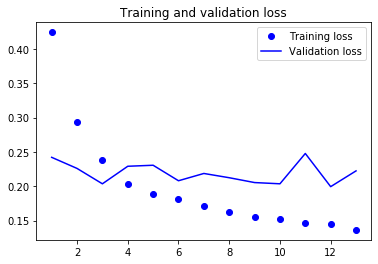

In [29]:
loss_lstm64 = history_lstm64.history['loss']
val_loss_lstm64 = history_lstm64.history['val_loss']

epochs = range(1, len(loss_lstm64) + 1)

plt.figure()

plt.plot(epochs, loss_lstm64, 'bo', label='Training loss')
plt.plot(epochs, val_loss_lstm64, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
print('Model Error:', f'{((min(val_loss_lstm64) * train_mw_std)/plant_capacity):0.2%}')

Model Error: 1.44%


In [31]:
lstm64 = ((min(val_loss_lstm64) * train_mw_std)/plant_capacity) * 100

<div id="lstm2"/>
<div style='padding:20px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5.2 LSTM with 32 nodes</font></div>

In [32]:
filepath_lstm32="clark_best_lstm32.hdf5" 
cp_lstm32 = ModelCheckpoint(filepath_lstm32, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
es_lstm32 = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=.01)
callbacks_list_lstm32 = [cp_lstm32, es_lstm32]

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)

model_lstm32 = Sequential()
model_lstm32.add(layers.LSTM(32, 
                       dropout=0.2,
                       recurrent_dropout=0.2, 
                       input_shape=(None, float_data.shape[-1])))
model_lstm32.add(layers.Dense(32, activation='relu'))
model_lstm32.add(layers.Dense(1))
model_lstm32.compile(optimizer=RMSprop(), loss='mae')

history_lstm32 = model_lstm32.fit_generator(train_gen,
                                        steps_per_epoch=steps_per_epoch_cnt, 
                                        epochs=50,
                                        validation_data=val_gen, 
                                        validation_steps=val_steps_cnt,
                                        callbacks=callbacks_list_lstm32, verbose=2) 

Epoch 1/50
20/20 [==============================] - 1s 34ms/step - loss: 0.2359

Epoch 00001: val_loss improved from inf to 0.23593, saving model to clark_best_lstm32.hdf5
 - 17s - loss: 0.4811 - val_loss: 0.2359
Epoch 2/50
20/20 [==============================] - 1s 30ms/step - loss: 0.2314

Epoch 00002: val_loss improved from 0.23593 to 0.23142, saving model to clark_best_lstm32.hdf5
 - 15s - loss: 0.3305 - val_loss: 0.2314
Epoch 3/50
20/20 [==============================] - 1s 31ms/step - loss: 0.2202

Epoch 00003: val_loss improved from 0.23142 to 0.22023, saving model to clark_best_lstm32.hdf5
 - 15s - loss: 0.2887 - val_loss: 0.2202
Epoch 4/50
20/20 [==============================] - 1s 30ms/step - loss: 0.2305

Epoch 00004: val_loss did not improve from 0.22023
 - 15s - loss: 0.2572 - val_loss: 0.2305
Epoch 5/50
20/20 [==============================] - 1s 30ms/step - loss: 0.2144

Epoch 00005: val_loss improved from 0.22023 to 0.21437, saving model to clark_best_lstm32.hdf5
 - 1

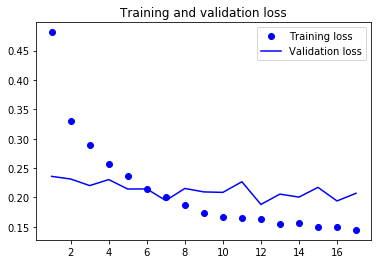

In [33]:
loss_lstm32 = history_lstm32.history['loss']
val_loss_lstm32 = history_lstm32.history['val_loss']

epochs = range(1, len(loss_lstm32) + 1)

plt.figure()

plt.plot(epochs, loss_lstm32, 'bo', label='Training loss')
plt.plot(epochs, val_loss_lstm32, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
print('Model Error:', f'{((min(val_loss_lstm32) * train_mw_std)/plant_capacity):0.2%}')

Model Error: 1.36%


In [35]:
lstm32 = ((min(val_loss_lstm32) * train_mw_std)/plant_capacity) * 100

<div id="lstm3"/>
<div style='padding:20px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5.3 Stacked LSTM with 64 and 32 nodes</font></div>

In [36]:
filepath_lstm6432="clark_best_lstm6432.hdf5" 
cp_lstm6432 = ModelCheckpoint(filepath_lstm6432, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
es_lstm6432 = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=.01)
callbacks_list_lstm6432 = [cp_lstm6432, es_lstm6432]

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)

model_lstm6432 = Sequential()
model_lstm6432.add(layers.LSTM(64,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model_lstm6432.add(layers.LSTM(32,
                    dropout=0.2,
                    recurrent_dropout=0.2))
model_lstm6432.add(layers.Dense(32, activation='relu'))
model_lstm6432.add(layers.Dense(1))
model_lstm6432.compile(optimizer=RMSprop(), loss='mae')

history_lstm6432 = model_lstm6432.fit_generator(train_gen,
                                             steps_per_epoch=steps_per_epoch_cnt,
                                             epochs=50,
                                             validation_data=val_gen, 
                                             validation_steps=val_steps_cnt,
                                             callbacks=callbacks_list_lstm6432, verbose=2)

Epoch 1/50
20/20 [==============================] - 2s 83ms/step - loss: 0.2134

Epoch 00001: val_loss improved from inf to 0.21343, saving model to clark_best_lstm6432.hdf5
 - 52s - loss: 0.4166 - val_loss: 0.2134
Epoch 2/50
20/20 [==============================] - 1s 65ms/step - loss: 0.2394

Epoch 00002: val_loss did not improve from 0.21343
 - 38s - loss: 0.2592 - val_loss: 0.2394
Epoch 3/50
20/20 [==============================] - 1s 73ms/step - loss: 0.2154

Epoch 00003: val_loss did not improve from 0.21343
 - 38s - loss: 0.2145 - val_loss: 0.2154
Epoch 4/50
20/20 [==============================] - 1s 63ms/step - loss: 0.2356

Epoch 00004: val_loss did not improve from 0.21343
 - 37s - loss: 0.1888 - val_loss: 0.2356
Epoch 5/50
20/20 [==============================] - 1s 65ms/step - loss: 0.2106

Epoch 00005: val_loss improved from 0.21343 to 0.21064, saving model to clark_best_lstm6432.hdf5
 - 37s - loss: 0.1734 - val_loss: 0.2106
Epoch 6/50
20/20 [=============================

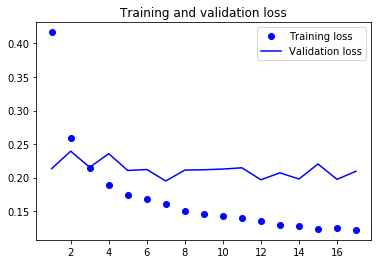

In [37]:
loss_lstm6432 = history_lstm6432.history['loss']
val_loss_lstm6432 = history_lstm6432.history['val_loss']

epochs = range(1, len(loss_lstm6432) + 1)

plt.figure()

plt.plot(epochs, loss_lstm6432, 'bo', label='Training loss')
plt.plot(epochs, val_loss_lstm6432, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
print('Model Error:', f'{((min(val_loss_lstm6432) * train_mw_std)/plant_capacity):0.2%}')

Model Error: 1.41%


In [39]:
lstm6432 = ((min(val_loss_lstm6432) * train_mw_std)/plant_capacity) * 100

<div id="lstm4"/>
<div style='padding:20px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5.4 Stacked LSTM with 32 and 64 nodes</font></div>

In [40]:
filepath_lstm3264 ="clark_best_lstm3264.hdf5" 
cp_lstm3264 = ModelCheckpoint(filepath_lstm3264, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
es_lstm3264 = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=.01)
callbacks_list_lstm3264 = [cp_lstm3264, es_lstm3264]

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)

model_lstm3264 = Sequential()
model_lstm3264.add(layers.LSTM(64,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model_lstm3264.add(layers.LSTM(32,
                    dropout=0.2,
                    recurrent_dropout=0.2))
model_lstm3264.add(layers.Dense(64, activation='relu'))
model_lstm3264.add(layers.Dense(1))
model_lstm3264.compile(optimizer=RMSprop(), loss='mae')

history_lstm3264 = model_lstm3264.fit_generator(train_gen,
                                             steps_per_epoch=steps_per_epoch_cnt,
                                             epochs=50,
                                             validation_data=val_gen, 
                                             validation_steps=val_steps_cnt,
                                             callbacks=callbacks_list_lstm3264, verbose=2)

Epoch 1/50
20/20 [==============================] - 2s 78ms/step - loss: 0.2272

Epoch 00001: val_loss improved from inf to 0.22722, saving model to clark_best_lstm3264.hdf5
 - 41s - loss: 0.4076 - val_loss: 0.2272
Epoch 2/50
20/20 [==============================] - 2s 75ms/step - loss: 0.2298

Epoch 00002: val_loss did not improve from 0.22722
 - 39s - loss: 0.2578 - val_loss: 0.2298
Epoch 3/50
20/20 [==============================] - 1s 66ms/step - loss: 0.2099

Epoch 00003: val_loss improved from 0.22722 to 0.20986, saving model to clark_best_lstm3264.hdf5
 - 41s - loss: 0.2111 - val_loss: 0.2099
Epoch 4/50
20/20 [==============================] - 1s 66ms/step - loss: 0.2387

Epoch 00004: val_loss did not improve from 0.20986
 - 37s - loss: 0.1871 - val_loss: 0.2387
Epoch 5/50
20/20 [==============================] - 1s 65ms/step - loss: 0.2111

Epoch 00005: val_loss did not improve from 0.20986
 - 37s - loss: 0.1708 - val_loss: 0.2111
Epoch 6/50
20/20 [=============================

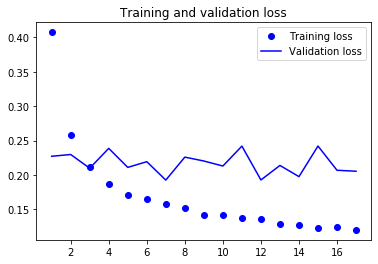

In [41]:
loss_lstm3264 = history_lstm3264.history['loss']
val_loss_lstm3264 = history_lstm3264.history['val_loss']

epochs = range(1, len(loss_lstm3264) + 1)

plt.figure()

plt.plot(epochs, loss_lstm3264, 'bo', label='Training loss')
plt.plot(epochs, val_loss_lstm3264, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [42]:
print('Model Error:', f'{((min(val_loss_lstm3264) * train_mw_std)/plant_capacity):0.2%}')

Model Error: 1.40%


In [43]:
lstm3264 = ((min(val_loss_lstm3264) * train_mw_std)/plant_capacity)  * 100

<div id="results"/>
<div style='padding:3px;'> <font style='font-weight:bold;font-size:20px;color:#2c3393;'>3. Results and Discussions</font></div>

<div id="res"/>
<div style='padding:10px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>3.1 Results</font></div>

In [44]:
names = ['Industry Agnostic Naive Method',
         'Industry Standard Naive Method', 
         'LSTM with 64 nodes',
         'LSTM with 32 nodes',
         'LSTM+LSTM with 64 nodes and 32 nodes',
         'LSTM+LSTM with 32 nodes and 64 nodes']
results = [benchmark1, 
           benchmark2,
           lstm64,
           lstm32,
           lstm6432,
           lstm3264]

In [45]:
results = pd.DataFrame(zip(names,results), columns=['Model', 'Error in Percentage'])

In [47]:
results['Error in Percentage'] = round(results['Error in Percentage'],2)

In [48]:
results['Improvement'] = round(1-(results['Error in Percentage']/3.64),4)*100

In [49]:
results

,Model,Error in Percentage,Improvement
0,Industry Agnostic Naive Method,8.87,143.68
1,Industry Standard Naive Method,3.64,0.00
2,LSTM with 64 nodes,1.44,60.44
3,LSTM with 32 nodes,1.36,62.64
4,LSTM+LSTM with 64 nodes and 32 nodes,1.41,61.26
5,LSTM+LSTM with 32 nodes and 64 nodes,1.40,61.54


<div id="res"/>
<div style='padding:10px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>3.2 Discussion and Recommendation</font></div>

Deep learning models, particularly Long-Short Term Memory, works very well with time series data that all neural networks performed more than 60% better than current industry standards. This improvements will save companies and the national grid operators money and make our power system more efficient. Companies will pay less paid due to miscalculations of projected generation and waste from generating too much power that are not bought by the market. Grid operators will save on repairs and downtimes caused by fluctuations in the power supply.

Further improvements in the model can be achieved further manipulation of the architecture of the network such as trying different numbers of nodes, layers, and optimizers in the LSTM layer, adding dense layers with different nodes, or even adding a CNN layer after the LSTM layer, as some have done. Another avenue for improvement is to obtain more data that are more indicative of solar power generation such as quality of solar panels, the angle they are placed, the irridiance per hour, altitude of the area, among others.

<div id="summary"/>
<div style='padding:3px;'> <font style='font-weight:bold;font-size:20px;color:#2c3393;'>4. Main Learning Points</font></div>

In this age of the 4th industrial revolution, technologies are making everything, even ones that require specialized technical knowledge, such as programming, available to all. Various programs enable anyone, who has a computer, internet connection, and interest, to create their own machine learning models. All these parameter tuning, model selection, and model evaluation are getting simpler and simpler to execute, but harder to explain. This is where a formal education in data science with good mathematical foundation brings an edge. Real self-respecting data scientists will be able to explain not just how to execute/program the pipline, but also how the actual algorithm works and how it was able to provide the results it did. There is a developed intuition from  having understand the fundamentals. This, together with industry expertise, will determine the success of a data scientist in the field.

Industry expertise is still important, as there are various intricacies in an industry that are not known to outsiders. These insights might be the determining factor in the increased performance of a model, or even its acceptance.